In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# GPU'yu seçmek ve yapılandırmak için gerekli ayarları yapın
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.set_visible_devices(gpus[0], 'GPU')

        # Mantıksal cihazları listeleyin ve GPU'nun aktif olduğunu doğrulayın
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# GPU'nun varsayılan cihaz olup olmadığını kontrol edin
print("Default GPU Device: ", tf.test.gpu_device_name())
print("Is GPU available: ", len(tf.config.list_physical_devices('GPU')) > 0)

1 Physical GPUs, 1 Logical GPUs
Default GPU Device:  /device:GPU:0
Is GPU available:  True


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "YaprakDataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 7137 files belonging to 6 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 4 4 4 1 4 3 4 5 3 1 4 4 3 4 4 4 4 4 1 3 3 4 1 4 0 0 4 4 4 4]


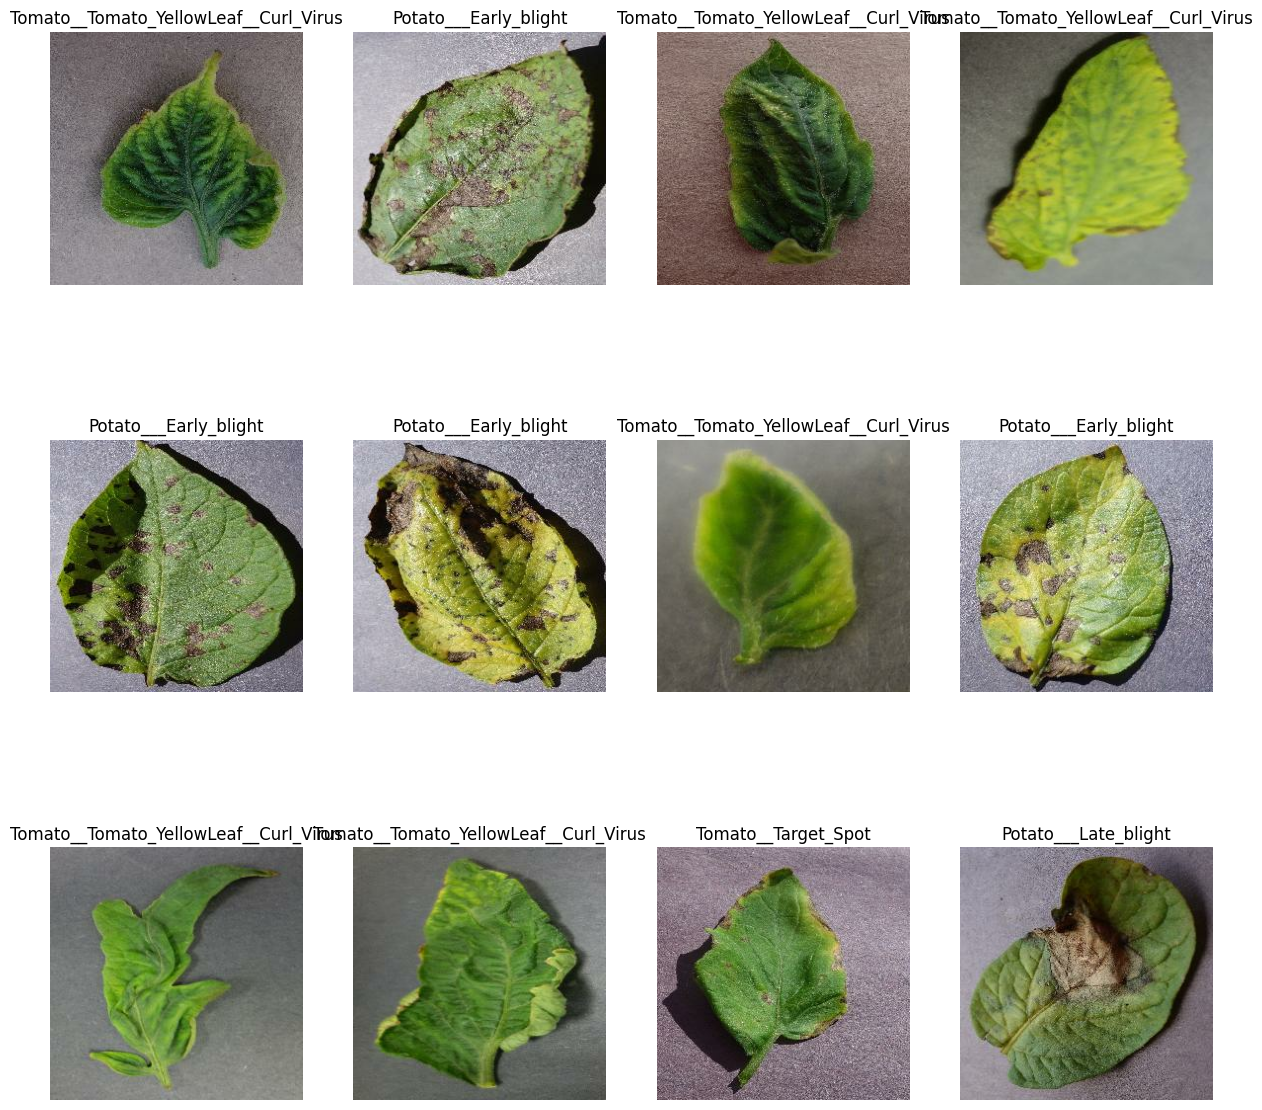

In [30]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [31]:
len(dataset)

224

In [32]:
train_size = 0.8
len(dataset)*train_size

179.20000000000002

In [33]:
train_ds = dataset.take(179)
len(train_ds)

179

In [34]:
test_ds = dataset.skip(179)
len(test_ds)

45

In [35]:
val_size=0.1
len(dataset)*val_size

22.400000000000002

In [16]:
val_ds = test_ds.take(22)
len(val_ds)

22

In [17]:
test_ds = test_ds.skip(22)
len(test_ds)

23

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

179

In [21]:
len(val_ds)

22

In [22]:
len(test_ds)

23

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
# add noise 
class AddNoise(tf.keras.layers.Layer):
    def __init__(self, noise_factor=0.1, **kwargs):
        super().__init__(**kwargs)
        self.noise_factor = noise_factor

    def call(self, inputs, training=True):
        if not training:
            return inputs
        noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.noise_factor)
        return inputs + noise

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  AddNoise(noise_factor=0.1),
  tf.keras.layers.RandomContrast(factor=0.1),
  tf.keras.layers.RandomBrightness(factor=0.1),
  tf.keras.layers.Rescaling(1./255),
])

In [26]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(factor=0.1),
    tf.keras.layers.RandomBrightness(factor=0.1),
])


In [28]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [38]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6 

# DNN modelinin tanımı
model = models.Sequential([
    layers.Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [39]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 196608)            0         
                                                                 
 dense_12 (Dense)            (None, 128)               25165952  
                                                                 
 dense_13 (Dense)            (None, 256)               33024     
                                                                 
 dense_14 (Dense)            (None, 512)               131584    
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 6)                

In [40]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [41]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
179/179 [==============================] - 31s 157ms/step - loss: 753.7352 - accuracy: 0.3888 - val_loss: 1.4984 - val_accuracy: 0.4261
Epoch 2/50
179/179 [==============================] - 13s 70ms/step - loss: 1.4671 - accuracy: 0.4509 - val_loss: 1.4958 - val_accuracy: 0.4261
Epoch 3/50
179/179 [==============================] - 12s 67ms/step - loss: 1.4677 - accuracy: 0.4513 - val_loss: 1.4960 - val_accuracy: 0.4261
Epoch 4/50
179/179 [==============================] - 12s 67ms/step - loss: 1.4684 - accuracy: 0.4506 - val_loss: 1.4959 - val_accuracy: 0.4261
Epoch 5/50
179/179 [==============================] - 12s 68ms/step - loss: 1.4650 - accuracy: 0.4532 - val_loss: 1.4980 - val_accuracy: 0.4261
Epoch 6/50
179/179 [==============================] - 11s 62ms/step - loss: 1.4681 - accuracy: 0.4502 - val_loss: 1.4958 - val_accuracy: 0.4261
Epoch 7/50
179/179 [==============================] - 11s 62ms/step - loss: 1.4675 - accuracy: 0.4504 - val_loss: 1.4960 - val_accura

45/45 [==============================] - 6s 28ms/step


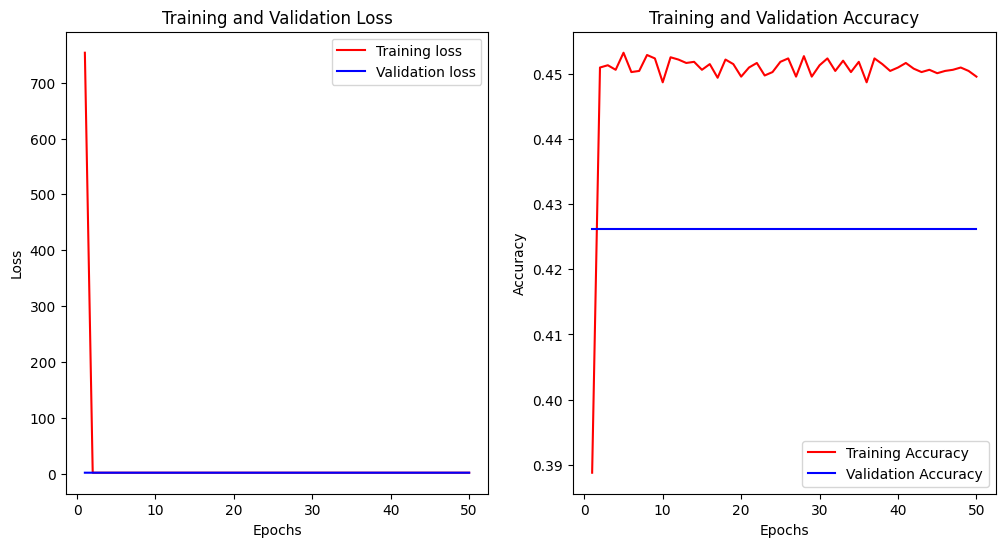

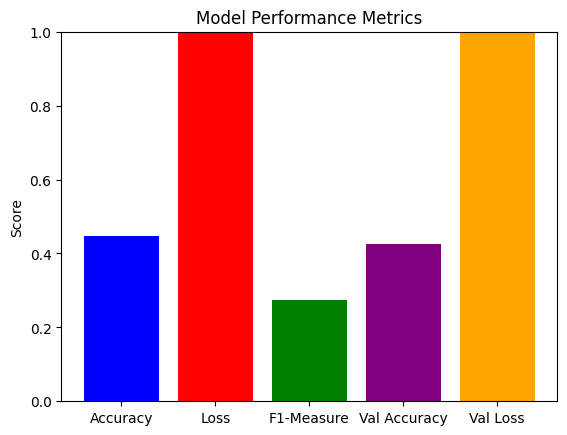

In [42]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Test veri setinde modelin performansını değerlendirme
test_loss, test_accuracy = model.evaluate(test_ds)

# Test veri setinde tahminler yapma
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# F1 skoru hesaplama
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Eğitim ve doğrulama metriklerini çıkarma
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Eğitim ve doğrulama metriklerini görselleştirme
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Değerlendirme metriklerini çubuk grafikle görselleştirme
metrics = {
    'Accuracy': test_accuracy,
    'Loss': test_loss,
    'F1-Measure': f1,
    'Val Accuracy': val_acc[-1],
    'Val Loss': val_loss[-1]
}

labels = list(metrics.keys())
values = list(metrics.values())

fig, ax = plt.subplots()
ax.bar(labels, values, color=['blue', 'red', 'green', 'purple', 'orange'])

ax.set_ylim(0, 1)
ax.set_title('Model Performance Metrics')
ax.set_ylabel('Score')
plt.show()


In [1]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

NameError: name 'test_ds' is not defined

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


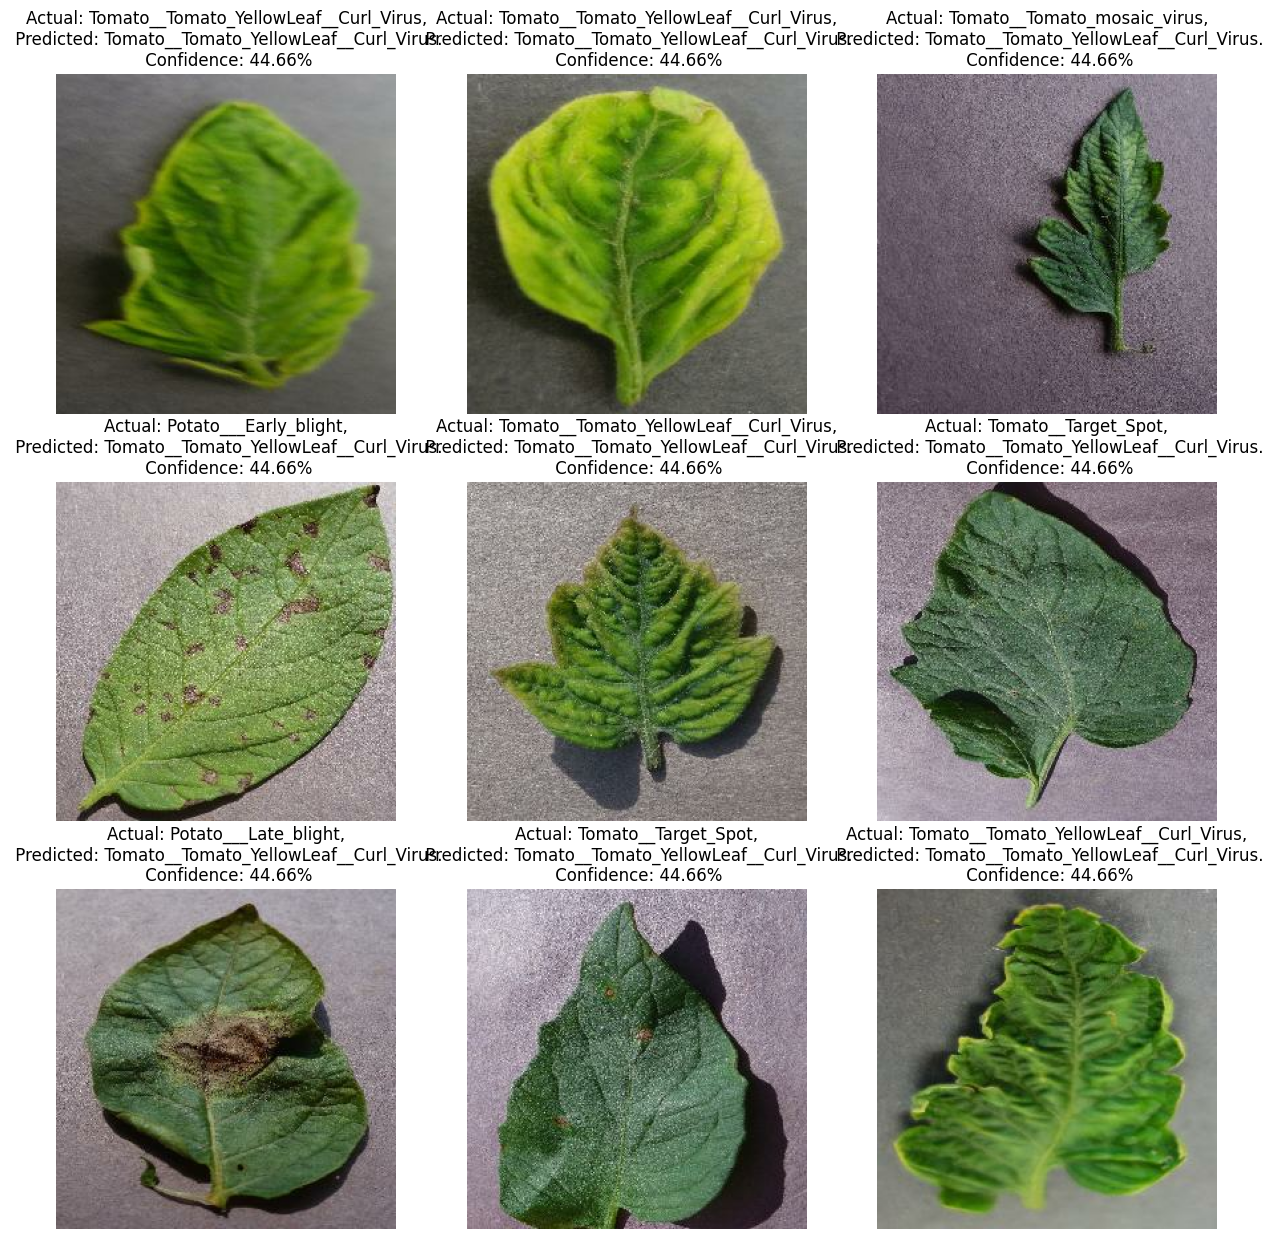

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

45/45 [==============================] - 6s 35ms/step


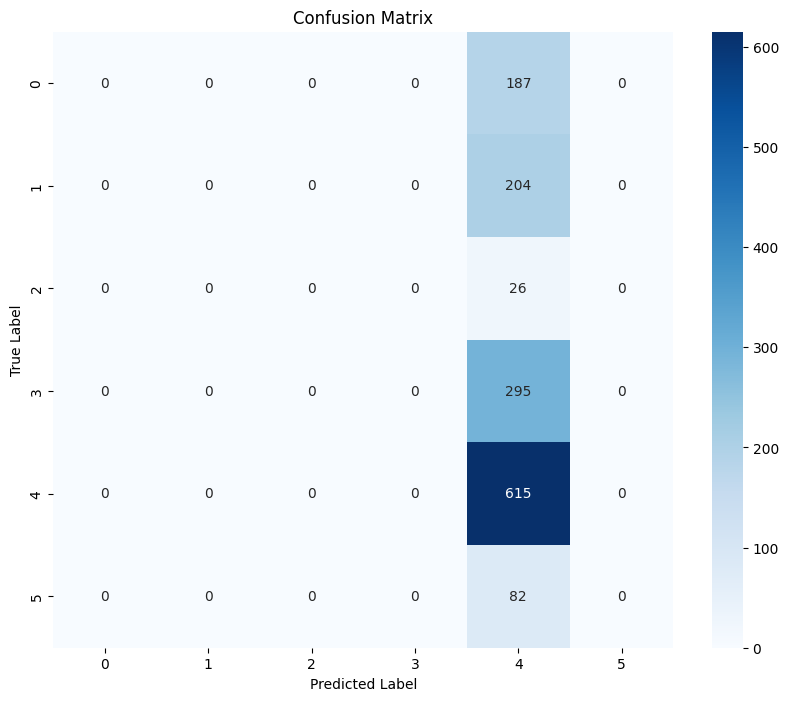

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Örnek karmaşıklık matrisi oluşturma kodu
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


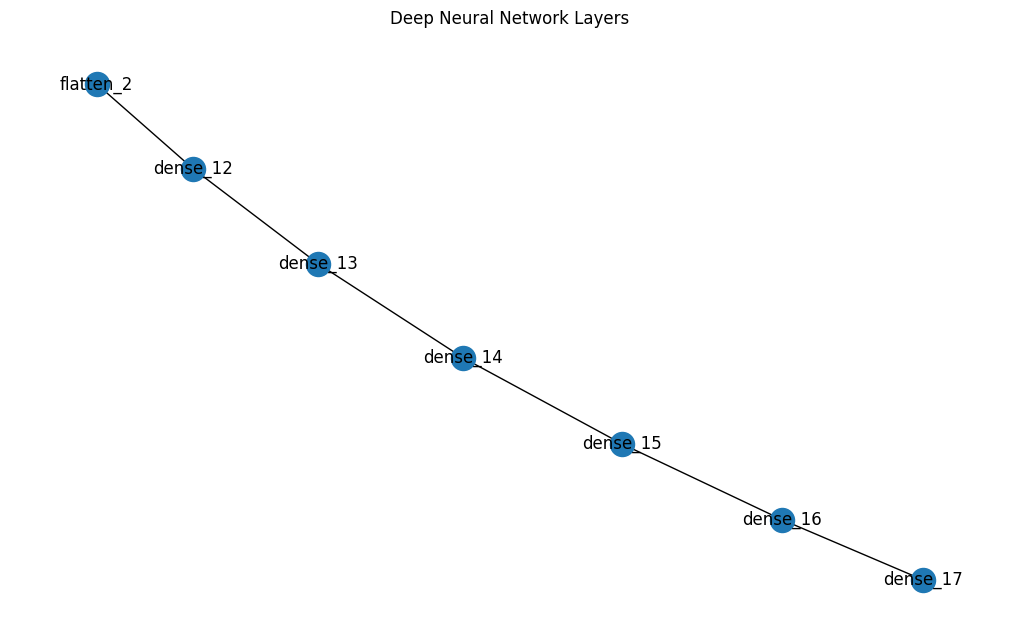

In [47]:
import networkx as nx
import matplotlib.pyplot as plt

# Boş bir Networkx grafik nesnesi oluşturun
G = nx.Graph()

# Model katmanlarını gezerek grafı oluşturun
for i, layer in enumerate(model.layers):
    layer_name = layer.name  # Katman adını alın
    G.add_node(layer_name)  # Katmanı grafa ekleyin
    if i > 0:  # İlk katman hariç
        prev_layer_name = model.layers[i - 1].name  # Önceki katmanın adını alın
        G.add_edge(prev_layer_name, layer_name)  # Önceki katman ile mevcut katman arasında bir kenar oluşturun

# Grafı çizdirin
plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=True)
plt.title('Deep Neural Network Layers')
plt.show()


45/45 [==============================] - 5s 33ms/step


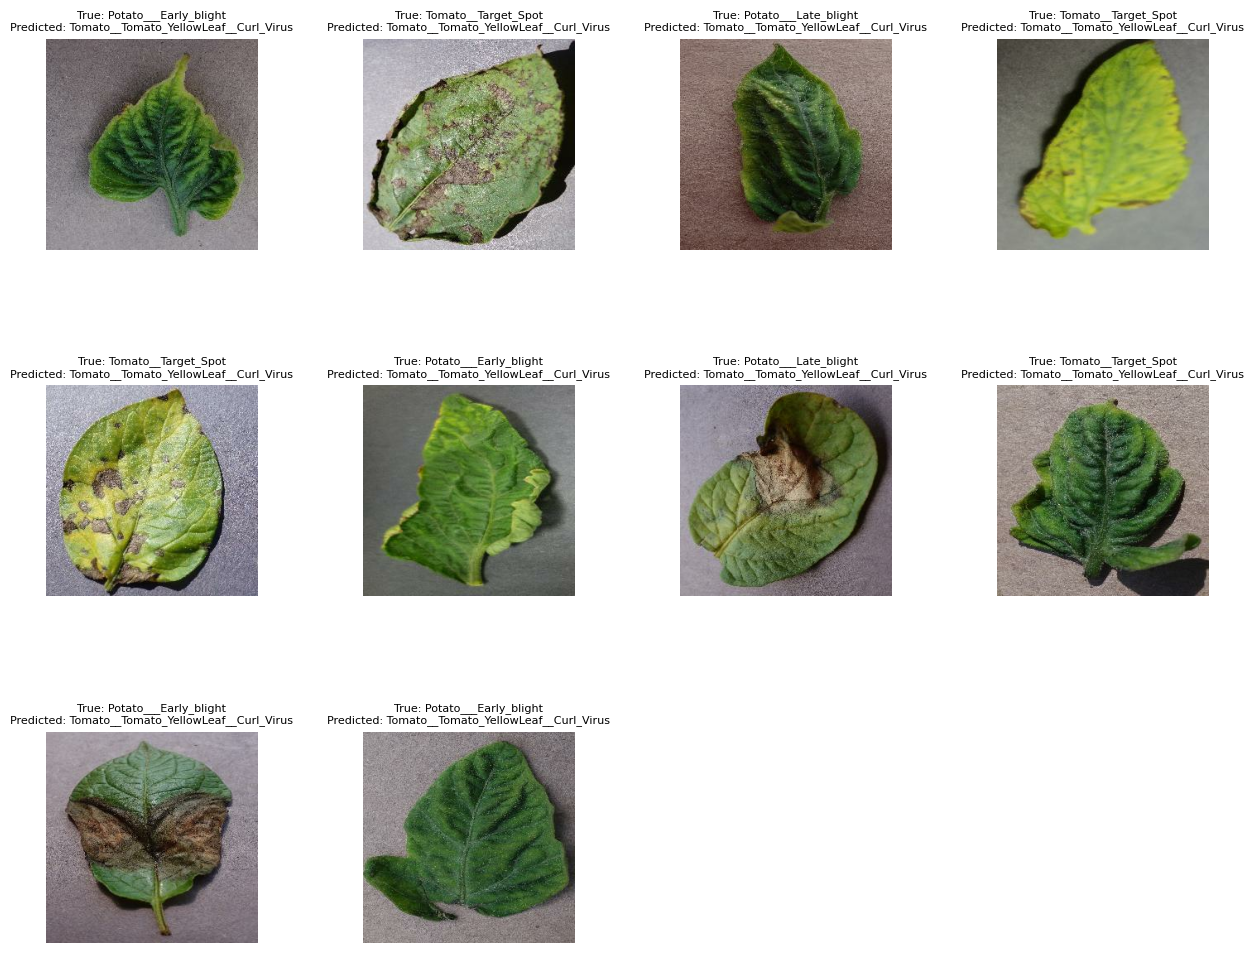

In [48]:
import numpy as np

# Test veri kümesini kullanarak modelin tahminlerini alın
predictions = model.predict(test_ds)

# Yanlış tahmin edilen örneklerin indekslerini bulun
incorrect_indices = np.where(np.argmax(predictions, axis=1) != y_true)[0]

# İlk 10 yanlış tahmin edilen örneği görselleştirme
plt.figure(figsize=(15, 12))
for i, incorrect_index in enumerate(incorrect_indices[:10]):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[incorrect_index].numpy().astype("uint8"))
    plt.title(f"True: {class_names[y_true[incorrect_index]]}\nPredicted: {class_names[np.argmax(predictions[incorrect_index])]}",
              fontsize=8)
    plt.axis("off")

plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Resimler arasına ve resimlerle başlıklar arasına boşluk bırakmak için

plt.show()
